# desilike

## Framework to specify DESI (clustering) likelihoods

### Tutorial #2: bindings with external inference codes

# Goals
At the end of the tutorial you will know:
- how to write likelihoods in terms of compressed parameters (e.g. based on forecasts), optionally with covariance between different measurements
- how to write full shape likelihoods, and emulate their theory
- how to run inference within desilike, or [Cobaya](https://github.com/CobayaSampler/cobaya), [CosmoSIS](https://github.com/joezuntz/cosmosis), and [MontePython](https://github.com/brinckmann/montepython_public).

For real-life examples, see the application to [mock Y1 cosmological inference](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_y1).

This is the continuation of the first tutorial, accessible here: https://github.com/cosmodesi/desilike-tutorials.

# Environment

Easiest is to use the cosmodesi environment at NERSC:
```
source /global/common/software/desi/users/adematti/cosmodesi_environment.sh main  # source the environment
${COSMODESIMODULES}/install_jupyter_kernel.sh main  # this to be done once
```
NB: to remove the previous kernel:
```
rm -rf ${HOME}/.local/share/jupyter/kernels/cosmodesi-main
```
To see these slides in a browser, e.g.:
```
firefox desilike_bindings.slides.html
```

# Compressed likelihoods

Let's first focus on compressed likelihoods = only depend on the cosmological model (nuisance = bias, stochastic and counterterms already marginalized out).

=> sampling of these likelihoods is typically fast enough that they do not need to be emulated.

## BAO likelihood

BAO likelihoods are built from a "BAO observable", that compares a data vector to a theory, typically $\alpha_{\perp}$ and $\alpha_{\parallel}$ or $D_{M}/r_{d}$ and $D_{H}/r_{d}$.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import jax; jax.config.update('jax_platform_name', 'cpu')

In [2]:
import numpy as np

from desilike import utils, setup_logging
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.observables.galaxy_clustering import BAOCompressionObservable

setup_logging()

# fiducial cosmology is DESI's by default
observable1 = BAOCompressionObservable(data=[1., 1.],
                                       covariance=np.diag([0.01, 0.01]),
                                       quantities=['qpar', 'qper'],
                                       z=1.)
# Let's define the likelihood from this observable
likelihood = ObservablesGaussianLikelihood(observable1)

### Reminder

In [3]:
# Likelihood parameters
print('varied likelihood parameters are', likelihood.varied_params.names())
# To evaluate the likelihood (return the logposterior)
print('logposterior is {:.3f}'.format(likelihood(Omega_m=0.29)))

[000000.10] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
varied likelihood parameters are ['Omega_m']
logposterior is -0.005


Why do we bother about "observables"?

... because we can join them in a likelihood!

In [4]:
# We want to share the same cosmological calculation among all observables
# so let's give it explicitly
from desilike.theories import Cosmoprimo
cosmo = Cosmoprimo(fiducial='DESI')
# Set Cosmoprimo calculator's parameters
cosmo.init.params = {'Omega_m': {'prior': {'limits': [0.1, 0.9]},
                                 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.002},
                                 'latex': '\Omega_m'}}
# Let's reuse the first observable we have defined, just updating the cosmo
observable1.init.update(cosmo=cosmo)
# Let's be fancy and rather define our observable in terms of DV_over_rd
# We provide a dictionary to "data": the theory vector will be generated automatically
observable2 = BAOCompressionObservable(data={}, quantities=['DV_over_rd'], z=1.5, cosmo=cosmo)
# Let's join the two observables, and provide the joint covariance
likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                           covariance=np.diag([0.01, 0.01, 1.]))
print('likelihood is {:.4f}'.format(likelihood()))

[000000.54] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000000.72] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['DV_over_rd'].
likelihood is -0.0000


We can also sum (log-) likelihoods!

In [5]:
likelihood2 = likelihood + likelihood
likelihood(Omega_m=0.29)
likelihood2(Omega_m=0.29)
assert np.allclose(likelihood2.loglikelihood, 2. * likelihood.loglikelihood)

## Bindings
To generate desilike bindings, let's start by writing a callable (~ "function") that returns the desilike likelihood.

In [6]:
def BAOLikelihood(cosmo='external'):
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    # = by the external cosmological inference code
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5,
                                           cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

### Cobaya
### 'Dynamic' bindings

Cobaya is built such that we can provide likelihoods defined on-the-fly (i.e. not in a Python script), and run inference from Python directly.

In [7]:
from desilike.bindings.cobaya import CobayaLikelihoodFactory

# CobayaBAOLikelihood is a Cobaya Likelihood object
CobayaBAOLikelihood = CobayaLikelihoodFactory(BAOLikelihood, params=True)

[000001.09] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000001.14] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000001.28] [0/1] 07-04 12:26  numexpr.utils             INFO     NumExpr defaulting to 8 threads.


In [8]:
from cosmoprimo.fiducial import DESI
cosmo = DESI()

# No magic here, this is all Cobaya stuff
params = {'Omega_m': {'prior': {'min': 0.1, 'max': 1.},
                      'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
                      'latex': '\Omega_{m}'},
          'omega_b': cosmo['omega_b'],
          'H0': cosmo['H0'],
          'A_s': cosmo['A_s'],
          'n_s': cosmo['n_s'],
          'tau_reio': cosmo['tau_reio']}

info = {'params': params,
        'likelihood': {'bao_likelihood': CobayaBAOLikelihood},
        'theory': {'classy': {'extra_args': {'N_ncdm': cosmo['N_ncdm'], 'N_ur': cosmo['N_ur']}}}}

from cobaya.model import get_model
model = get_model(info)
model.logposterior({'Omega_m': cosmo['Omega_m']})

[000001.48] [0/1] 07-04 12:26  classy                    INFO     `classy` module loaded successfully from /home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/classy-3.2.0-py3.9-linux-x86_64.egg
[000001.53] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000001.58] [0/1] 07-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qiso'].


LogPosterior(logpost=0.10471144781489061, logpriors=[0.10536051565782628], loglikes=array([-0.00064907]), derived=[], finite=False)

In [9]:
# Let's run MCMC!
info_sampler = {'mcmc': {'Rminus1_stop': 0.02}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model)
mcmc.run()

[000004.39] [0/1] 07-04 12:26  mcmc                      INFO     Getting initial point... (this may take a few seconds)
[000004.45] [0/1] 07-04 12:26  model                     INFO     Measuring speeds... (this may take a few seconds)
[000004.59] [0/1] 07-04 12:26  model                     INFO     Setting measured speeds (per sec): {bao_likelihood: 601.0, classy: 22.5}
[000004.59] [0/1] 07-04 12:26  mcmc                      INFO     Initial point: Omega_m:0.3093999
[000004.59] [0/1] 07-04 12:26  mcmc                      INFO     Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[000004.59] [0/1] 07-04 12:26  mcmc                      INFO     Sampling!
[000004.65] [0/1] 07-04 12:26  mcmc                      INFO     Progress @ 2023-07-04 12:26:26 : 1 steps taken, and 0 accepted.
[000006.72] [0/1] 07-04 12:26  mcmc                      INFO     Learn + convergence test @ 40 samples accepted.
[

[000059.46] [0/1] 07-04 12:27  mcmc                      INFO      - Acceptance rate: 0.447
[000059.46] [0/1] 07-04 12:27  mcmc                      INFO      - Convergence of means: R-1 = 0.031286 after 544 accepted steps
[000059.46] [0/1] 07-04 12:27  mcmc                      INFO      - Updated covariance matrix of proposal pdf.
[000062.99] [0/1] 07-04 12:27  mcmc                      INFO     Learn + convergence test @ 720 samples accepted.
[000063.00] [0/1] 07-04 12:27  mcmc                      INFO      - Acceptance rate: 0.442
[000063.00] [0/1] 07-04 12:27  mcmc                      INFO      - Convergence of means: R-1 = 0.049249 after 576 accepted steps
[000063.00] [0/1] 07-04 12:27  mcmc                      INFO      - Updated covariance matrix of proposal pdf.
[000064.66] [0/1] 07-04 12:27  mcmc                      INFO     Progress @ 2023-07-04 12:27:26 : 1517 steps taken, and 738 accepted.
[000066.70] [0/1] 07-04 12:27  mcmc                      INFO     Learn + conver

[000074.76] [0/1] 07-04 12:27  root                      WARNING  outlier fraction 0.10952380952380952 


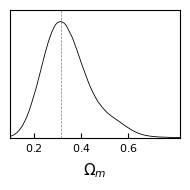

In [10]:
from getdist.mcsamples import MCSamplesFromCobaya
samples_bao_cobaya = mcmc.samples(combined=True, skip_samples=0.5, to_getdist=True).copy(label='cobaya')
from getdist import plots
g = plots.get_subplot_plotter()
g.triangle_plot(samples_bao_cobaya, params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### Interlude: let's do the same within desilike

In [11]:
from desilike.samplers import MCMCSampler

from desilike.theories import Cosmoprimo
cosmo = Cosmoprimo(fiducial='DESI')
# Set Cosmoprimo calculator's parameters
cosmo.init.params = {'Omega_m': {'prior': {'limits': [0.1, 1.]},
                                 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
                                 'latex': '\Omega_m'}}
sampler = MCMCSampler(BAOLikelihood(cosmo=cosmo), seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.03, 'stable_over': 2}, check_every=40)
# do help(chains[0]) to get info on the available methods!
samples_bao_desilike = chains[0].remove_burnin(0.5).to_getdist(label='desilike')

[000075.35] [0/1] 07-04 12:27  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000075.41] [0/1] 07-04 12:27  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000075.52] [0/1] 07-04 12:27  MCMCSampler               INFO     Varied parameters: ['Omega_m'].
[000076.12] [0/1] 07-04 12:27  BasePipeline              INFO     Found speeds:
[000076.12] [0/1] 07-04 12:27  BasePipeline              INFO     - <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x7f76d10474f0>: 1085.06 iterations / second
[000076.12] [0/1] 07-04 12:27  BasePipeline              INFO     - <desilike.theories.galaxy_clustering.power_template.BAOExtractor object at 0x7f76d10475e0>: 20.02 iterations / second
[000076.12] [0/1] 07-04 12:27  BasePipeline              INFO     - <desilike.observables.galaxy_clustering.compression.BAOCompressionObservable object at 0x7f76d0fee160>: 4222.17 iterations / second
[000076.12] [0/1] 07-04 12:27  BasePipeline              INFO     - 

[000106.24] [0/1] 07-04 12:28  MCMCSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0264.
[000106.26] [0/1] 07-04 12:28  MCMCSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0624.
[000106.26] [0/1] 07-04 12:28  MCMCSampler               INFO     - max Geweke is 0.43.
[000106.27] [0/1] 07-04 12:28  MCMCSampler               INFO     - Geweke p-value is nan.
[000106.27] [0/1] 07-04 12:28  MCMCSampler               INFO     - (160 iterations / integrated autocorrelation time) (reliable) is 160.
[000106.27] [0/1] 07-04 12:28  MCMCSampler               INFO     - max variation of integrated autocorrelation time is 0.0771.
[000106.33] [0/1] 07-04 12:28  MCMCSampler               INFO     Updating proposal covariance.
[000110.33] [0/1] 07-04 12:28  MCMCSampler               INFO     Diagnostics:
[000110.33] [0/1] 07-04 12:28  MCMCSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0308; not < 0.03.
[000110.34] [0/1] 07-04 12:28  MCMCSam

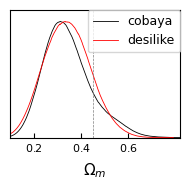

In [12]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### 'Static' bindings

Other inference codes (CosmoSIS, MontePython) typically require the likelihood to be written down in a file,
such that it is imported by the code.
Let's illustrate this, still with Cobaya.

In [13]:
!rm -rf _tests

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [14]:
utils.mkdir('_tests')

In [15]:
%%file _tests/bao_likelihood.py

dirname = '.'

def BAOLikelihood(cosmo='external'):
    import numpy as np
    from desilike.observables.galaxy_clustering import BAOCompressionObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator
    # We could provide a list of Likelihoods, which will all be written at once
    CobayaLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})

Writing _tests/bao_likelihood.py


Let's generate the static bindings by calling the above Python script

In [16]:
%%bash
cd _tests/
python bao_likelihood.py

bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by bash)


Let's take a look at the generated files:
- the Python module containing the Cobaya likelihood: ``bao_likelihood.py``
- imported in the ``__init__.py``
- the ``.yaml`` config file containing the nuisance parameters (none in this case)

In [17]:
!ls -la _tests/cobaya

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  4 12:28 .
drwxr-xr-x 3 adematti idphp 4096 juil.  4 12:28 ..
-rw-r--r-- 1 adematti idphp  477 juil.  4 12:28 bao_likelihood.py
-rw-r--r-- 1 adematti idphp   31 juil.  4 12:28 BAOLikelihood.yaml
-rw-r--r-- 1 adematti idphp   30 juil.  4 12:28 __init__.py


In [18]:
!cat _tests/cobaya/BAOLikelihood.yaml

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
params: {}
stop_at_error: true


In [19]:
# %load _tests/cobaya/bao_likelihood.py
# NOTE: This code has been automatically generated by desilike.bindings.cobaya.factory.CobayaLikelihoodGenerator
from desilike.bindings.cobaya.factory import CobayaLikelihoodFactory

from desilike.bindings.base import load_from_file
BAOLikelihood = load_from_file('/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike-tutorials/_tests/bao_likelihood.py', 'BAOLikelihood')
BAOLikelihood = CobayaLikelihoodFactory(BAOLikelihood, 'BAOLikelihood', {'cosmo': 'external'}, __name__)



Now let's write the config file to run inference. This is pure Cobaya.

In [20]:
%%file _tests/config_bao.yaml

theory:
  classy:
    extra_args:
      N_ncdm: 1
      N_ur: 2.0328

likelihood:
  bao_likelihood.BAOLikelihood:
      python_path: _tests/cobaya

params:
  Omega_m:
    prior:
      min: 0.1
      max: 1.
    ref:
      dist: norm
      loc: 0.3
      scale: 0.01
    latex: \Omega_{m}
  omega_b: 0.02237
  H0: 67.36
  As: 2.083e-09
  n_s: 0.9649
  tau_reio: 0.0544

sampler:
  mcmc:
    Rminus1_stop: 0.02

debug: False

output: _tests/chains_bao_cobaya/chain


Writing _tests/config_bao.yaml


Let's sample!

In [21]:
!cobaya-run _tests/config_bao.yaml

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[output] Output to be read-from/written-into folder '_tests/chains_bao_cobaya', with prefix 'chain'
[absl] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[absl] Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[absl] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[absl] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[absl] *WARNING* No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[classy] `classy` module loaded successfully from /home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/classy-3.2.0-py3.9-linux-x86_64.egg
[BAOCompressionObservable] Found quantities ['qpar', 'qper'].
[BAOCompressionObserva

[000166.92] [0/1] 07-04 12:29  root                      WARNING  outlier fraction 0.075 


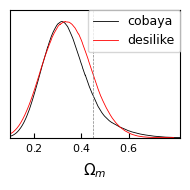

In [22]:
# To load Cobaya samples from disk
from getdist.mcsamples import loadMCSamples
samples_bao_cobaya = loadMCSamples('_tests/chains_bao_cobaya/chain', settings={'ignore_rows': 0.5}).copy(label='cobaya')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### CosmoSIS
Let's apply the static bindings to CosmoSIS.
The BAOLikelihood definition is exactly the same, we just need to generate new files with a simple CosmoSISLikelihoodGenerator call.

In [23]:
%%file _tests/bao_likelihood.py

dirname = '.'

# The same as for Cobaya!
def BAOLikelihood(cosmo='external'):
    import numpy as np
    from desilike.observables.galaxy_clustering import BAOCompressionObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})
    # The only change!
    CosmoSISLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})
    # Let's directly generate the bindings for MontePython
    MontePythonLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})

Overwriting _tests/bao_likelihood.py


Let's generate the static bindings by calling the above Python script

In [24]:
%%bash
cd _tests
python bao_likelihood.py

bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by bash)


Let's take a look at the generated files:
- the likelihood module: ``BAOLikelihood.py``
- the ``*values.ini`` file containing the values / ranges of nuisance parameters (none in this case), to be copy-pasted in the input ``*values.ini`` (see below)
- the ``*priors.ini`` file containing the optional priors of nuisance parameters, to be copy-pasted in the input ``*priors.ini`` file

In [25]:
ls -la _tests/cosmosis

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  4 12:29 ./
drwxr-xr-x 7 adematti idphp 4096 juil.  4 12:29 ../
-rw-r--r-- 1 adematti idphp    7 juil.  4 12:29 BAOLikelihood_priors.ini
-rw-r--r-- 1 adematti idphp  543 juil.  4 12:29 BAOLikelihood.py
-rw-r--r-- 1 adematti idphp    7 juil.  4 12:29 BAOLikelihood_values.ini


Now let's write the config file to run inference. This is pure CosmoSIS.

In [26]:
%%file _tests/config_bao.ini

[DEFAULT]
fatal_errors = T

[runtime]
sampler = emcee

[output]
filename = _tests/chains_bao_cosmosis/chain.txt
format = text
verbosity = 0

[pipeline]
modules = consistency camb bao
values = _tests/values_bao.ini
likelihoods = BAOLikelihood  ; notice the name of the liklelihood: the same as the *.py file
quiet = T
debug = F
timing = F

[consistency]
file = ${COSMOSIS_STD_DIR}/utility/consistency/consistency_interface.py

[camb]
file = ${COSMOSIS_STD_DIR}/boltzmann/camb/camb_interface.py
mode = background
feedback = 0
nz = 901

[bao]
file = _tests/cosmosis/BAOLikelihood.py

[emcee]
walkers = 6
samples = 600
nsteps = 20

Writing _tests/config_bao.ini


The ``*values.ini`` file containing parameter values and ranges

In [27]:
%%file _tests/values_bao.ini

[cosmological_parameters]

; This is the only parameter being varied.
omega_m = 0.1 0.3 0.9
ombh2 = 0.02237
h0 = 0.6736
A_s = 2.083e-09
n_s = 0.9649
tau = 0.0544

mnu = 0.06
nnu = 3.046
num_massive_neutrinos = 1
omega_k = 0.0
w = -1.0
wa = 0.0

Writing _tests/values_bao.ini


Let's sample!

In [28]:
!cosmosis _tests/config_bao.ini

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Parameter Priors
----------------
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--ombh2                  ~ delta(0.02237)
cosmological_parameters--h0                     ~ delta(0.6736)
cosmological_parameters--a_s                    ~ delta(2.083e-09)
cosmological_parameters--n_s                    ~ delta(0.9649)
cosmological_parameters--tau                    ~ delta(0.0544)
cosmological_parameters--mnu                    ~ delta(0.06)
cosmological_parameters--nnu                    ~ delta(3.046)
cosmological_parameters--num_massive_neutrinos  ~ delta(1)
cosmological_parameters--omega_k                ~ delta(0.0)
cosmological_parameters--w                      ~ delta(-1.0)
cosmological_parameters--wa                     ~ delta(0.0)

****************************
* Running sampler 1/1: emcee
* Saving output -> _tests

LOADING CHAIN FROM FILE:  _tests/chains_bao_cosmosis/chain.txt


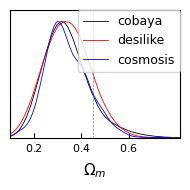

In [29]:
# To load CosmoSIS samples from disk
from cosmosis import Inifile
from cosmosis.output import input_from_options
from getdist import MCSamples

ini = Inifile('_tests/config_bao.ini')
options = dict(ini.items('output'))
options['filename'] = '_tests/chains_bao_cosmosis/chain.txt'
column_names, data = input_from_options(options)[:2]
#print(column_names)
data = data[0].T
data = data[..., data.shape[-1] // 2:]  # removing burnin
samples_bao_cosmosis = MCSamples(samples=[data[0]], weights=None, loglikes=-data[-1],
                                 names=['Omega_m'], label='cosmosis')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike, samples_bao_cosmosis],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### MontePython

MontePython is not a Python package, so is not installed in the cosmodesi environment.

Let's install it locally! (it may take some time to download, because of the data sets).

In [30]:
%%bash
cd _tests/
git clone https://github.com/brinckmann/montepython_public.git

bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by bash)
Cloning into 'montepython_public'...
Updating files: 100% (1492/1492), done.


We write the ``.conf`` file that specifies the path to the Boltzman code Class and Planck likelihoods.

In [31]:
%%file _tests/montepython_public/default.conf

import os
path['cosmo'] = os.getenv('CLASS_STD_DIR')
path['clik'] = os.path.join(os.getenv('PLANCK_SRC_DIR'), 'code', 'plc_3.0', 'plc-3.1')

Writing _tests/montepython_public/default.conf


Let's take a look at the files previously generated by the static bindings:

- the package: ``BAOLikelihood``
- with a (mandatory) ``*.data`` file specifying the likelihood name and nuisance parameter priors
- with ``*.param`` file specifying parameter ranges, to be copy-pasted in the input ``.param`` file (see below)
- with the ``__init__.py`` file containing the likelihood definition

As required by MontePython, we copy all this to the ``montepython/likelihoods`` directory.

In [32]:
!ls -la _tests/montepython/BAOLikelihood
!cp -r _tests/montepython/BAOLikelihood _tests/montepython_public/montepython/likelihoods/

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  4 12:29 .
drwxr-xr-x 3 adematti idphp 4096 juil.  4 12:29 ..
-rw-r--r-- 1 adematti idphp   35 juil.  4 12:29 BAOLikelihood.data
-rw-r--r-- 1 adematti idphp   52 juil.  4 12:29 BAOLikelihood.param
-rw-r--r-- 1 adematti idphp  502 juil.  4 12:29 __init__.py
/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Now let's write the config file to run inference. This is pure MontePython.

In [33]:
%%file _tests/conf_bao.param

data.experiments = ['BAOLikelihood']

#------ Parameter list -------
# data.parameters[class name] = [mean, min, max, 1-sigma, scale, role]

# Cosmological parameters list
data.parameters['Omega_m'] = [0.3, 0.1, 0.9, 0.1, 1., 'cosmo']
# Fixed parameters
data.parameters['omega_b'] = [0.02237, 0.001, 0.1, 0., 1., 'cosmo']
data.parameters['H0'] = [67.36, 0.1, 0.9, 0., 1., 'cosmo']
data.parameters['A_s'] = [2.083e-09, 1e-09, 3e-09, 0., 1., 'cosmo']
data.parameters['n_s'] = [0.9649, 0.9, 1.0, 0., 1., 'cosmo']
data.parameters['tau_reio'] = [0.0544, 0.02, 0.1, 0., 1., 'cosmo']

# Cosmo arguments
data.cosmo_arguments['k_pivot'] = 0.05
data.cosmo_arguments['N_ur'] = 2.0328
data.cosmo_arguments['N_ncdm'] = 1
data.cosmo_arguments['m_ncdm'] = 0.06
data.cosmo_arguments['T_ncdm'] = 0.71611

#------ MCMC parameters ----
data.N = 3000
data.write_step = 5

Writing _tests/conf_bao.param


Let's sample!

In [34]:
!python _tests/montepython_public/montepython/MontePython.py run --conf _tests/montepython_public/default.conf -p _tests/conf_bao.param -o _tests/chains_bao_montepython

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.0

with CLASS v3.2.0

Testing likelihoods for:
 ->BAOLikelihood

Creating _tests/chains_bao_montepython/2023-07-04_3000__1.txt


Deduced starting covariance matrix:

['Omega_m']
[[0.01]]
Update routine is enabled with value 50 (recommended: 50)
This number is rescaled by cycle length 1 (N_slow + f_fast * N_fast) to 50

#  -LogLkl	Omega_m         
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
1  1.2712	4.891116e-01	
4  0.281176	2.528636e-01	
1  1.23541	4.861781e-01	
2  2.41229	5.732025e-01	
1  2.52404	5.807800e-01	
2  0.976066	2.066826e-01	
4  2.19677	5.583416e-01	
1  0.626529	4.305624e-01	
1  0.177274	3.729755e-

2  0.586808	4.263734e-01	
8  0.046422	3.438601e-01	
1  2.34682	1.596436e-01	
7  0.0942533	2.778984e-01	
2  0.442846	2.385309e-01	
1  0.1291	3.640301e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-04_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 93 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.041730 	for  Omega_m
--> Not computing covariance matrix
4  0.0392549	2.907597e-01	
2  0.0185243	3.331235e-01	
2  0.436917	4.094815e-01	
2  1.21586	1.960997e-01	
1  1.04847	4.703797e-01	
3  0.452862	4.113752e-01	
1  0.0118918	3.295245e-01	
1  1.17056	1.979856e-01	
2  1.04253	4.698635e-01	
2  0.355994	2.457498e-01	
2  0.0142325	3.308843e-01	
2  0.596873	2.275978e-01	
1  0.323118	3.950642e-01	
5  1.15086	1.988207e-01	
1  0.425779	4.081427e-01	
4  0.13603	2.707900e-01	
3  0.291649	2.518059e-01	
1  0.0115631	3.018032e-01	
1  0.0874451	3.549988e-01	
2  0.609794	2.267639e-01	
4  0.399604	2.42007

1  0.00341735	3.079195e-01	
2  0.509568	2.335477e-01	
2  0.00452876	3.240310e-01	
2  0.00768497	3.042680e-01	
1  0.0031576	3.225822e-01	
3  0.00243517	3.216916e-01	
1  0.000335472	3.129943e-01	
1  0.185676	2.637890e-01	
3  0.085204	3.544629e-01	
3  0.177537	3.730210e-01	
7  2.39601	5.720921e-01	
2  0.0276003	3.371549e-01	
3  0.387625	2.430102e-01	
1  0.725471	4.405901e-01	
4  0.70466	2.209544e-01	
2  0.217636	2.598335e-01	
1  0.124774	2.725695e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-04_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 195 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.059163 	for  Omega_m
--> Not computing covariance matrix
1  1.881	5.358675e-01	
5  0.0661209	3.496097e-01	
5  0.132027	2.714131e-01	
2  0.0218569	2.968509e-01	
2  0.21691	3.795633e-01	
4  2.57497	5.842067e-01	
3  1.93508	5.397837e-01	
3  0.572194	4.248056e-01	
4  1.67842	5.209092e-01	
3  0.89238

7  5.11215e-06	3.150546e-01	
2  0.328468	2.482541e-01	
1  0.379674	2.436859e-01	
1  0.0986868	3.575976e-01	
5  0.0142076	3.003638e-01	
1  0.215534	2.600830e-01	
3  0.150807	3.682152e-01	
4  0.0501021	3.450093e-01	
1  0.282088	3.893729e-01	
2  2.98019	6.109527e-01	
3  0.801519	4.479636e-01	
6  0.158093	2.675269e-01	
2  0.318085	2.492309e-01	
12  0.0173701	3.325483e-01	
1  1.0899	2.014670e-01	
1  1.14774	4.788733e-01	
1  1.36734	4.968679e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-04_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 295 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.025088 	for  Omega_m
--> Not computing covariance matrix
3  0.652997	4.332989e-01	
2  0.177079	3.729416e-01	
1  0.140426	3.662495e-01	
3  0.285354	2.524389e-01	
4  0.685441	2.220898e-01	
1  0.373136	2.442480e-01	
1  0.039341	3.415220e-01	
2  0.0599956	2.851759e-01	
2  0.171326	2.656913e-01	
3  0.654863	

2  6.81546	8.421443e-01	
1  2.94885	6.089140e-01	
1  0.787069	4.465825e-01	
3  0.2178	3.797052e-01	
1  0.122064	2.730110e-01	
2  0.358979	2.454853e-01	
1  0.456189	2.374997e-01	
8  0.794612	2.158860e-01	
2  0.516954	4.187382e-01	
6  0.697845	4.378438e-01	
1  0.975175	2.067249e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-04_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 398 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001159 	for  Omega_m
--> Not computing covariance matrix
2  0.286891	3.900558e-01	
3  0.548092	4.221872e-01	
7  2.65891	5.898203e-01	
1  1.53606	5.100876e-01	
4  0.621296	4.300164e-01	
3  0.0514894	3.454323e-01	
3  1.10951	4.756319e-01	
1  0.17106	3.718873e-01	
1  0.298912	2.510852e-01	
4  0.0404505	3.419006e-01	
1  0.400345	2.419461e-01	
2  0.265016	3.869047e-01	
1  0.0239249	3.356123e-01	
1  0.397787	4.047159e-01	
1  0.62319	4.302142e-01	
3  0.211499	3.786963e-

1  0.118302	3.618322e-01	
6  0.688766	4.369326e-01	
3  1.75671	5.267467e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-04_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 498 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.002377 	for  Omega_m
--> Not computing covariance matrix
1  0.917247	4.587258e-01	
1  0.324363	3.952321e-01	
1  1.03466	4.691772e-01	
1  0.411054	2.410658e-01	
3  1.79058	1.755109e-01	
6  0.0173524	3.325393e-01	
1  0.55907	4.233851e-01	
3  0.32354	2.487155e-01	
3  0.127262	3.636618e-01	
2  0.0148271	3.000472e-01	
8  1.91954e-05	3.158819e-01	
1  0.00252152	3.218043e-01	
1  0.372354	4.015179e-01	
1  0.00248676	3.090000e-01	
2  0.499102	4.167247e-01	
1  0.241273	3.833587e-01	
1  0.36868	4.010487e-01	
2  2.66479	5.902118e-01	
1  2.93052	6.077190e-01	
1  2.40781	5.728973e-01	
1  0.114236	3.609819e-01	
6  0.34837	2.464316e-01	
1  0.31056	2.499508e-01	
1  0.168786	3.7148

1  0.0105388	3.024064e-01	
5  0.294289	3.910988e-01	
3  0.00330487	3.080414e-01	
1  1.46417	1.865267e-01	
1  0.51223	4.182080e-01	
4  3.1886	1.402356e-01	
4  0.456128	2.375044e-01	
2  0.24617	2.565755e-01	
1  0.0947359	3.567003e-01	
9  0.00507785	3.245493e-01	
1  0.0262699	3.366085e-01	
3  1.86537	5.347297e-01	
2  1.89554	5.369230e-01	
1  2.45326	5.759907e-01	
7  0.295394	3.912535e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-04_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 600 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001867 	for  Omega_m
--> Not computing covariance matrix
5  2.22365	1.629017e-01	
2  0.052893	2.869506e-01	
2  0.790294	4.468916e-01	
5  0.0499879	3.449742e-01	
2  1.8369	1.740646e-01	
5  1.60981	1.814208e-01	
3  0.283888	2.525876e-01	
2  1.40248	4.996600e-01	
2  0.563382	4.238533e-01	
1  0.224831	2.589899e-01	
1  0.400391	4.050387e-01	
1  0.814878	4.492327e

[000482.10] [0/1] 07-04 12:34  root                      WARNING  outlier fraction 0.10832025117739404 


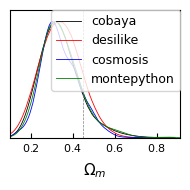

In [35]:
# To load MontePython samples from disk
from datetime import date
from getdist.mcsamples import loadMCSamples
samples_bao_montepython = loadMCSamples('_tests/chains_bao_montepython/{}_3000_'.format(date.today()),
                                    settings={'ignore_rows': 0.5}).copy(label='montepython')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike, samples_bao_cosmosis, samples_bao_montepython],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

## Interlude: forecasts
So far we have input totally ad-hoc covariance matrices.
Yet, one can use desilike to produce forecasts.

In [36]:
from desilike.observables.galaxy_clustering import CutskyFootprint
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, SimpleBAOWigglesTracerPowerSpectrumMultipoles
from desilike.likelihoods.galaxy_clustering import SNWeightedPowerSpectrumLikelihood
from desilike import Fisher

cosmo = DESI()

# Object holding the area and n(z) in (Mpc/h)^(-3)
footprint = CutskyFootprint(area=14000., zrange=np.linspace(0.8, 1.2, 10), nbar=np.full(10, 1e-4), cosmo=cosmo)
z = footprint.zavg

fo = cosmo.get_fourier()
s, s0 = fo.sigma8_z(z, of='delta_cb'), fo.sigma8_z(0., of='delta_cb')
b1 = 0.8 / (s / s0)  # prescription for linear bias
r = 0.5  # reconstruction factor
sigmaper = 9.4 * (s / 0.9)
f = fo.sigma8_z(z, of='theta_cb') / s
params = {'b1': b1, 'sigmapar': r * (1. + f) * sigmaper, 'sigmaper': r * sigmaper}  # fiducial model parameters
covariance_params = {'b1': b1, 'sigmapar': 0., 'sigmaper': 0.}  # fiducial covariance parameters (simple Kaiser model)
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qparqper')
theory = SimpleBAOWigglesTracerPowerSpectrumMultipoles(template=template) # this BAO model shifts wiggles only
for param in theory.init.params.select(basename='al*'):
    param.update(value=0., fixed=True)  # fixing broadband parameters (the wiggles only shift)

# For klim=(0.01, 0.5), we only use the information from the BAO feature in the power spectrum
likelihood = SNWeightedPowerSpectrumLikelihood(theories=theory, data=params, covariance=covariance_params,
                                               footprints=footprint, klim=(0.01, 0.5))
fisher = Fisher(likelihood)  # initializing Fisher
fisher_bao = fisher(**params).view(params=['qpar', 'qper'])  # computing Fisher prediction at fiducial parameters

[000483.58] [0/1] 07-04 12:34  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'sigmas'].
[000483.64] [0/1] 07-04 12:34  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'sigmas'].
[000483.98] [0/1] 07-04 12:34  Differentiation           INFO     Using finite-differentiation for parameter qpar.
[000484.06] [0/1] 07-04 12:34  Differentiation           INFO     Using finite-differentiation for parameter qper.
[000484.51] [0/1] 07-04 12:34  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000484.74] [0/1] 07-04 12:34  Differentiation           INFO     Using auto-differentiation for parameter sigmas.
[000484.74] [0/1] 07-04 12:34  Differentiation           INFO     qpar grid is [0.998 1.    1.002].
[000484.74] [0/1] 07-04 12:34  Differentiation           INFO     qper grid is [0.998 1.    1.002].


In [37]:
print(fisher_bao.to_stats(tablefmt='pretty'))

+-----+---------+
| FoM | 3601.51 |
+-----+---------+
+------+-------+-------+
|      | qpar  | qper  |
+------+-------+-------+
| mean | 1.000 | 1.000 |
| std  | 0.019 | 0.016 |
+------+-------+-------+
+------+---------+---------+
|      |  qpar   |  qper   |
+------+---------+---------+
| qpar | 3.6e-4  | -1.3e-4 |
| qper | -1.3e-4 | 2.6e-4  |
+------+---------+---------+


In [38]:
quantities = ['qpar', 'qper']
# You can directly pass Fisher to BAOCompressionObservable
observable = BAOCompressionObservable(data=fisher_bao, covariance=fisher_bao,
                                      quantities=quantities, z=z)
# Or...
observable = BAOCompressionObservable(data=fisher_bao.mean(quantities),
                                      covariance=fisher_bao.covariance(quantities),
                                      quantities=quantities, z=z)

This observable can be passed to a likelihood, just as previously, to further run cosmological inference.

## ShapeFit likelihood
ShapeFit compressed likelihoods are similar to BAO compressed likelihoods.

In [39]:
from desilike.observables.galaxy_clustering import ShapeFitCompressionObservable

observable = ShapeFitCompressionObservable(data=[1., 1., 1., 0.], covariance=np.diag([0.01, 0.01, 0.01, 0.01]),
                                           quantities=['qpar', 'qper', 'df', 'dm'], z=1.)
# Let's define the likelihood from this observable
likelihood = ObservablesGaussianLikelihood(observable)

This observable can be passed to a likelihood, just as previously, to further run cosmological inference.

# Full likelihoods

Let's write full likelihoods, i.e. with nuisance parameters (bias, stochastic and counterterms not marginalized out).

In [40]:
%%file _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood(cosmo='external'):
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix, TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # Let's define the template = linear power spectrum
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    b1 = 0.5
    footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
                 covariance=None,  # path to mocks, array (covariance matrix), or None
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory)  # previously defined theory
    covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
    cov = covariance(b1=b1)  # evaluate covariance matrix at this parameter
    likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
    observable.init.update(data=observable.flatdata)  # fix the data vector
    template.init.update(cosmo=cosmo)  # let's pass the cosmology
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})
    CosmoSISLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})
    MontePythonLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})

Writing _tests/fs_likelihood.py


Let's generate the static bindings by calling the above Python script

In [41]:
!python _tests/fs_likelihood.py

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [42]:
!ls -la _tests/cobaya

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 32
drwxr-xr-x  3 adematti idphp 4096 juil.  4 12:34 .
drwxr-xr-x 10 adematti idphp 4096 juil.  4 12:34 ..
-rw-r--r--  1 adematti idphp  477 juil.  4 12:29 bao_likelihood.py
-rw-r--r--  1 adematti idphp   31 juil.  4 12:29 BAOLikelihood.yaml
-rw-r--r--  1 adematti idphp  471 juil.  4 12:34 fs_likelihood.py
-rw-r--r--  1 adematti idphp  411 juil.  4 12:34 FSLikelihood.yaml
-rw-r--r--  1 adematti idphp   59 juil.  4 12:34 __init__.py
drwxr-xr-x  2 adematti idphp 4096 juil.  4 12:28 __pycache__


In [43]:
!ls -la _tests/cosmosis

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 36
drwxr-xr-x  3 adematti idphp 4096 juil.  4 12:34 .
drwxr-xr-x 10 adematti idphp 4096 juil.  4 12:34 ..
-rw-r--r--  1 adematti idphp    7 juil.  4 12:29 BAOLikelihood_priors.ini
-rw-r--r--  1 adematti idphp  543 juil.  4 12:29 BAOLikelihood.py
-rw-r--r--  1 adematti idphp    7 juil.  4 12:29 BAOLikelihood_values.ini
-rw-r--r--  1 adematti idphp  110 juil.  4 12:34 FSLikelihood_priors.ini
-rw-r--r--  1 adematti idphp  536 juil.  4 12:34 FSLikelihood.py
-rw-r--r--  1 adematti idphp  101 juil.  4 12:34 FSLikelihood_values.ini
drwxr-xr-x  2 adematti idphp 4096 juil.  4 12:29 __pycache__


In [44]:
!ls -la _tests/montepython

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 16
drwxr-xr-x  4 adematti idphp 4096 juil.  4 12:34 .
drwxr-xr-x 10 adematti idphp 4096 juil.  4 12:34 ..
drwxr-xr-x  2 adematti idphp 4096 juil.  4 12:29 BAOLikelihood
drwxr-xr-x  2 adematti idphp 4096 juil.  4 12:34 FSLikelihood


Yet, the above likelihood will take a significant time to evaluate, especially for a 1-loop EFT model.
Let's emulate the theory.

In [45]:
# %load _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood(cosmo='external'):
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix, TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # Let's define the template = linear power spectrum
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    b1 = 1.5
    footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
                 covariance=None,  # path to mocks, array (covariance matrix), or None
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory)  # previously defined theory
    covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
    cov = covariance(b1=b1)  # evaluate covariance matrix at this parameter
    likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
    observable.init.update(data=observable.flatdata)  # fix the data vector
    template.init.update(cosmo=cosmo)  # let's pass the cosmology
    return likelihood

In [46]:
likelihood = FSLikelihood(cosmo=None)
theory = likelihood.observables[0].wmatrix.theory

from desilike.emulators import Emulator, TaylorEmulatorEngine, EmulatedCalculator

emulator = Emulator(theory.pt,
                    engine=TaylorEmulatorEngine(order={'*': 1}))
emulator.set_samples()
emulator.fit()  # set Taylor expansion

# Emulator can be saved with:
emulator.save('_tests/emulator.npy')
np.save('_tests/data.npy', likelihood.flatdata)
np.save('_tests/covariance.npy', likelihood.covariance)

theory.init.update(pt=emulator)

[000511.14] [0/1] 07-04 12:34  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'omega_b', 'logA'].
[000511.14] [0/1] 07-04 12:34  Emulator                  INFO     Found varying ['pk_dd', 'pk_dt', 'pk_tt', 'pk11'] and fixed ['k', 'z', 'ells', 'names'] outputs.
[000511.64] [0/1] 07-04 12:34  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'omega_b', 'logA'].
[000514.81] [0/1] 07-04 12:34  Differentiation           INFO     Using finite-differentiation for parameter h.
[000515.42] [0/1] 07-04 12:34  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000516.05] [0/1] 07-04 12:34  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[000516.56] [0/1] 07-04 12:34  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000516.56] [0/1] 07-04 12:34  Differentiation           INFO     h grid is [0.6706 0.6736 0.6766].
[000516.56] [0/1] 07-04 12:34 

Now we can write our likelihood, using the emulated PT!

In [47]:
%%file _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood():
    import os
    import numpy as np
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    from desilike.emulators import EmulatedCalculator
    # Let's define the template
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template,
                                                 pt=EmulatedCalculator.load(os.path.join(dirname, 'emulator.npy')))
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data=np.load(os.path.join(dirname, 'data.npy')),  # path to data, *pypower* file, array, or dictionary of parameters
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory,
                 covariance=np.load(os.path.join(dirname, 'covariance.npy')))
    likelihood = ObservablesGaussianLikelihood(observables=observable)
    likelihood.all_params['b1'].update(ref=dict(limits=[1., 2.]))
    likelihood.all_params['sn0'].update(derived='.auto')
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})
    CosmoSISLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})
    MontePythonLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})

Overwriting _tests/fs_likelihood.py


Let's generate the static bindings by calling the above Python script

In [48]:
!python _tests/fs_likelihood.py

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Cobaya

In [49]:
%%file _tests/config_bao_fs.yaml

theory:
  classy:
    extra_args:
      N_ncdm: 1
      N_ur: 2.0328

likelihood:
  bao_likelihood.BAOLikelihood:
      python_path: _tests/cobaya
  fs_likelihood.FSLikelihood:
      python_path: _tests/cobaya

params:
  Omega_m:
    prior:
      min: 0.1
      max: 1.
    ref:
      dist: norm
      loc: 0.3
      scale: 0.01
    latex: \Omega_{m}
  omega_b: 0.02237
  H0: 67.36
  As: 2.083e-09
  n_s: 0.9649
  tau_reio: 0.0544

sampler:
  mcmc:
    Rminus1_stop: 0.05

debug: False

output: _tests/chains_bao_fs_cobaya/chain

Writing _tests/config_bao_fs.yaml


Let's sample!

In [50]:
!cobaya-run _tests/config_bao_fs.yaml

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[output] Output to be read-from/written-into folder '_tests/chains_bao_fs_cobaya', with prefix 'chain'
[absl] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[absl] Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[absl] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[absl] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[absl] *WARNING* No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[classy] `classy` module loaded successfully from /home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/classy-3.2.0-py3.9-linux-x86_64.egg
[BAOCompressionObservable] Found quantities ['qpar', 'qper'].
[BAOCompressionObse

In [51]:
from getdist.mcsamples import loadMCSamples
samples_bao_fs_cobaya = loadMCSamples('_tests/chains_bao_fs_cobaya/chain',
                                      settings={'ignore_rows': 0.5}).copy(label='cobaya')

[000649.43] [0/1] 07-04 12:37  root                      WARNING  outlier fraction 0.1076923076923077 


### CosmoSIS

In [52]:
%%file _tests/config_bao_fs.ini

[DEFAULT]
fatal_errors = T

[runtime]
sampler = emcee

[output]
filename = _tests/chains_bao_fs_cosmosis/chain.txt
format = text
verbosity = 0

[pipeline]
modules = consistency camb bao fs
values = _tests/values_bao_fs.ini
likelihoods = BAOLikelihood FSLikelihood  ; notice the name of the liklelihood: the same as the *.py file
quiet = T
debug = F
timing = F

[consistency]
file = ${COSMOSIS_STD_DIR}/utility/consistency/consistency_interface.py

[camb]
file = ${COSMOSIS_STD_DIR}/boltzmann/camb/camb_interface.py
mode = background
feedback = 0
; We need quite fine redshift spacing, because the supernovae
; go down to low z where things are pretty sensitive
nz = 901

[bao]
file = _tests/cosmosis/BAOLikelihood.py

[fs]
file = _tests/cosmosis/FSLikelihood.py

[emcee]
walkers = 10
samples = 800
nsteps = 20

Writing _tests/config_bao_fs.ini


In this case the likelihood has nuisance parameters, to be copied in the input ``*values.ini`` file.

In [53]:
!cat _tests/cosmosis/FSLikelihood_values.ini

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[desi]
sigmapar = 0.0
sigmaper = 0.0
b1 = 0.0 1.5 4.0


In [54]:
%%file _tests/values_bao_fs.ini

[desi]
sigmapar = 0.0
sigmaper = 0.0
b1 = 0.0 1.5 4.0

[cosmological_parameters]
; This is the only parameter being varied.
omega_m = 0.1 0.3 0.9
ombh2 = 0.02237
h0 = 0.6736
A_s = 2.083e-09
n_s = 0.9649
tau = 0.0544

mnu = 0.06
nnu = 3.046
num_massive_neutrinos = 1
omega_k = 0.0
w = -1.0
wa = 0.0

Writing _tests/values_bao_fs.ini


Let's sample!

In [55]:
!cosmosis _tests/config_bao_fs.ini

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Parameter Priors
----------------
desi--sigmapar                                  ~ delta(0.0)
desi--sigmaper                                  ~ delta(0.0)
desi--b1                                        ~ U(0.0, 4.0)
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--ombh2                  ~ delta(0.02237)
cosmological_parameters--h0                     ~ delta(0.6736)
cosmological_parameters--a_s                    ~ delta(2.083e-09)
cosmological_parameters--n_s                    ~ delta(0.9649)
cosmological_parameters--tau                    ~ delta(0.0544)
cosmological_parameters--mnu                    ~ delta(0.06)
cosmological_parameters--nnu                    ~ delta(3.046)
cosmological_parameters--num_massive_neutrinos  ~ delta(1)
cosmological_parameters--omega_k                ~ delta(0.0)
cosmological_parameters

In [56]:
# To load CosmoSIS samples
from cosmosis import Inifile
from cosmosis.output import input_from_options
from getdist import MCSamples

ini = Inifile('_tests/config_bao_fs.ini')
options = dict(ini.items('output'))
options['filename'] = '_tests/chains_bao_fs_cosmosis/chain.txt'
column_names, data = input_from_options(options)[:2]
#print(column_names)
data = data[0].T
data = data[:2, data.shape[-1] // 2::10]  # removing burnin and thinning
samples_bao_fs_cosmosis = MCSamples(samples=np.column_stack(data), weights=None, loglikes=-data[-1],
                                    names=['b1', 'Omega_m'], label='cosmosis')

LOADING CHAIN FROM FILE:  _tests/chains_bao_fs_cosmosis/chain.txt


### MontePython

In [57]:
!ls -la _tests/montepython/FSLikelihood
!cp -r _tests/montepython/FSLikelihood _tests/montepython_public/montepython/likelihoods/

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  4 12:34 .
drwxr-xr-x 4 adematti idphp 4096 juil.  4 12:34 ..
-rw-r--r-- 1 adematti idphp   33 juil.  4 12:35 FSLikelihood.data
-rw-r--r-- 1 adematti idphp  268 juil.  4 12:35 FSLikelihood.param
-rw-r--r-- 1 adematti idphp  477 juil.  4 12:35 __init__.py
/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In this case the likelihood has nuisance parameters, to be copied in the input ``*.param`` file.

In [58]:
!cat _tests/montepython/FSLikelihood/FSLikelihood.param

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
# To be copy-pasted in the MontePython *.param file
data.parameters['sigmapar'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['sigmaper'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['b1'] = [1.5, 0.0, 4.0, 0.28867513459481287, 1.0, 'nuisance']


In [59]:
%%file _tests/conf_bao_fs.param

data.experiments = ['BAOLikelihood', 'FSLikelihood']

# Cosmological parameters list
data.parameters['Omega_m'] = [0.3, 0.1, 0.9, 0.1, 1., 'cosmo']
# Fixed parameters
data.parameters['omega_b'] = [0.02237, 0.001, 0.1, 0., 1., 'cosmo']
data.parameters['H0'] = [67.36, 0.1, 0.9, 0., 1., 'cosmo']
data.parameters['A_s'] = [2.083e-09, 1e-09, 3e-09, 0., 1., 'cosmo']
data.parameters['n_s'] = [0.9649, 0.9, 1.0, 0., 1., 'cosmo']
data.parameters['tau_reio'] = [0.0544, 0.02, 0.1, 0., 1., 'cosmo']

# Nuisance parameters list
data.parameters['sigmapar'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['sigmaper'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['b1'] = [1.5, 0.0, 4.0, 0.28867513459481287, 1.0, 'nuisance']

# Cosmo arguments
data.cosmo_arguments['k_pivot'] = 0.05
# The base model features two massless
# and one massive neutrino with m=0.06eV.
# The settings below ensures that Neff=3.046
# and m/omega = 93.14 eV
data.cosmo_arguments['N_ur'] = 2.0328
data.cosmo_arguments['N_ncdm'] = 1
data.cosmo_arguments['m_ncdm'] = 0.06
data.cosmo_arguments['T_ncdm'] = 0.71611

#------ MCMC parameters ----
# Number of steps taken, by default (overwritten by the -N command)
data.N = 9000
# Number of accepted steps before writing to file the chain. Larger means less
# access to disc, but this is not so much time consuming.
data.write_step = 5

Writing _tests/conf_bao_fs.param


Let's sample!

In [60]:
!python _tests/montepython_public/montepython/MontePython.py run --conf _tests/montepython_public/default.conf -p _tests/conf_bao_fs.param -o _tests/chains_bao_fs_montepython

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.0

with CLASS v3.2.0

Testing likelihoods for:
 ->BAOLikelihood, FSLikelihood

Creating _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt


Deduced starting covariance matrix:

['Omega_m', 'b1']
[[0.01 0.  ]
 [0.   0.08]]
Update routine is enabled with value 50 (recommended: 50)
This number is rescaled by cycle length 2 (N_slow + f_fast * N_fast) to 100

#  -LogLkl	Omega_m         b1              
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Step  90  chain  0 : Failed to calculate covariance matrix
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if 

3  -2.23309	3.100295e-01	1.525477e+00	
1  -1.82527	3.061246e-01	1.529667e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 66 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000168 	for  Omega_m
           0.007558 	for  b1
--> Not computing covariance matrix
1  -1.44137	3.061246e-01	1.514825e+00	
2  -2.28429	3.084074e-01	1.512375e+00	
2  -2.21753	3.081921e-01	1.512606e+00	
1  -2.93659	3.113700e-01	1.509196e+00	
2  -2.71525	3.113700e-01	1.503263e+00	
4  -2.92453	3.113700e-01	1.508415e+00	
2  -2.94113	3.113700e-01	1.509640e+00	
1  -2.93167	3.113700e-01	1.508836e+00	
2  -3.10954	3.142779e-01	1.505715e+00	
1  -3.01076	3.120064e-01	1.508153e+00	
1  -3.0126	3.120064e-01	1.508628e+00	
1  -3.07947	3.129023e-01	1.507667e+00	
3  -2.97388	3.129023e-01	1.511482e+00	
2  -2.96919	3.123583e-01	1.512066e+00	
1  -2.82239	3.151253e-01	1.509096e+00	

1  -2.53223	3.145372e-01	1.513856e+00	
2  -2.35039	3.155147e-01	1.512808e+00	
1  -2.70675	3.130578e-01	1.515444e+00	
3  -3.06233	3.130578e-01	1.503060e+00	
1  -3.10742	3.135456e-01	1.502537e+00	
2  -3.125	3.135456e-01	1.504570e+00	
1  -2.64552	3.135456e-01	1.493956e+00	
1  -3.02182	3.173498e-01	1.489874e+00	
1  -2.81404	3.173498e-01	1.485935e+00	
1  -2.77234	3.199445e-01	1.483151e+00	
1  -2.68596	3.199445e-01	1.492741e+00	
1  -2.81444	3.193245e-01	1.493406e+00	
1  -2.77219	3.193245e-01	1.494330e+00	
2  -3.05236	3.175358e-01	1.496249e+00	
1  -3.06765	3.173900e-01	1.496406e+00	
3  -3.09411	3.173900e-01	1.493968e+00	
1  -3.07	3.177152e-01	1.493619e+00	
1  -2.8931	3.177152e-01	1.499449e+00	
1  -2.93073	3.117644e-01	1.505835e+00	
1  -2.50171	3.117644e-01	1.498811e+00	
1  -3.01556	3.146269e-01	1.495739e+00	
1  -2.96637	3.146269e-01	1.508281e+00	
3  -2.22402	3.077932e-01	1.515614e+00	
1  -2.31359	3.077932e-01	1.522630e+00	
6  -2.45679	3.086096e-01	1.521753e+00	
1  -2.30864	3.077684e-01	1.5226

2  -2.39959	3.102469e-01	1.504088e+00	
1  -1.66786	3.102469e-01	1.497409e+00	
1  -2.47512	3.128174e-01	1.494651e+00	
2  -3.02431	3.128174e-01	1.510220e+00	
1  -2.68277	3.128174e-01	1.496916e+00	
1  -2.56343	3.122885e-01	1.497484e+00	
1  -2.19486	3.122885e-01	1.522056e+00	
2  -2.3243	3.101981e-01	1.524299e+00	
1  -2.3102	3.094499e-01	1.525102e+00	
1  -2.10904	3.094499e-01	1.504511e+00	
1  -2.92466	3.127019e-01	1.501022e+00	
1  -2.76338	3.127019e-01	1.515388e+00	
1  -2.70833	3.134691e-01	1.514565e+00	
1  -2.74868	3.134691e-01	1.514075e+00	
2  -2.37873	3.158896e-01	1.511478e+00	
1  -1.61244	3.185198e-01	1.508655e+00	
1  -1.77035	3.185198e-01	1.507617e+00	
1  -2.39055	3.080809e-01	1.518818e+00	
3  -2.35748	3.080809e-01	1.516854e+00	
1  -2.3813	3.081725e-01	1.516755e+00	
3  -2.1425	3.081725e-01	1.511536e+00	
1  -3.08813	3.153268e-01	1.503860e+00	
4  -3.1221	3.153268e-01	1.502796e+00	
1  -3.16438	3.153268e-01	1.499145e+00	
1  -2.9403	3.182604e-01	1.495998e+00	
1  -2.93797	3.182604e-01	1.4960

2  -2.32495	3.081405e-01	1.524075e+00	
1  -1.99126	3.081405e-01	1.509718e+00	
1  -0.914387	3.056512e-01	1.512389e+00	
1  -1.68465	3.056512e-01	1.531099e+00	
1  -1.88332	3.066300e-01	1.530048e+00	
2  -1.31089	3.066300e-01	1.537026e+00	
3  -1.35259	3.066300e-01	1.536648e+00	
1  -1.28018	3.058798e-01	1.537453e+00	
1  -1.83408	3.058798e-01	1.526425e+00	
1  -1.74346	3.161184e-01	1.515438e+00	
5  -3.15142	3.161184e-01	1.498024e+00	
3  -3.14542	3.162680e-01	1.497864e+00	
1  -3.08194	3.162680e-01	1.500950e+00	
1  -2.72172	3.186233e-01	1.498423e+00	
1  -1.97662	3.186233e-01	1.505790e+00	
1  -2.84404	3.146637e-01	1.510038e+00	
2  -3.0049	3.146637e-01	1.507490e+00	
1  -1.67798	3.146637e-01	1.519953e+00	
1  -2.21423	3.116047e-01	1.523236e+00	
1  -2.92552	3.116047e-01	1.513246e+00	
1  -1.57996	3.197654e-01	1.504489e+00	
1  -1.65641	3.197654e-01	1.503973e+00	
2  -1.42732	3.203462e-01	1.503349e+00	
1  -2.54108	3.168108e-01	1.507143e+00	
1  -2.01533	3.168108e-01	1.479408e+00	
1  -1.29655	3.140039e-01	

1  -2.63307	3.102461e-01	1.519919e+00	
1  -2.65309	3.106644e-01	1.519470e+00	
1  -2.10252	3.106644e-01	1.499245e+00	
1  -2.80153	3.134209e-01	1.496288e+00	
3  -3.06754	3.134209e-01	1.508358e+00	
2  -2.86494	3.161816e-01	1.505396e+00	
1  -2.79442	3.166198e-01	1.504925e+00	
1  -2.92419	3.166198e-01	1.503040e+00	
4  -2.777	3.104731e-01	1.509635e+00	
2  -2.82316	3.172443e-01	1.502370e+00	
2  -3.09587	3.148369e-01	1.504953e+00	
1  -2.59895	3.183234e-01	1.501212e+00	
4  -2.71449	3.183234e-01	1.482931e+00	
1  -3.01226	3.183234e-01	1.492774e+00	
1  -2.76391	3.199246e-01	1.491056e+00	
1  -2.19684	3.199246e-01	1.499069e+00	
2  -2.80616	3.175000e-01	1.501671e+00	
2  -3.03662	3.158812e-01	1.503408e+00	
3  -3.0745	3.127295e-01	1.506790e+00	
2  -2.48783	3.127295e-01	1.518504e+00	
1  -2.6994	3.127295e-01	1.516171e+00	
1  -0.927588	3.196644e-01	1.508729e+00	
2  -1.57313	3.196644e-01	1.504901e+00	
3  -2.85154	3.196644e-01	1.489826e+00	
2  -2.70821	3.204498e-01	1.488983e+00	
1  -3.05331	3.153490e-01	1.4

3  -2.63162	3.097368e-01	1.519587e+00	
1  -2.20106	3.097368e-01	1.526136e+00	
1  -2.06434	3.119897e-01	1.523719e+00	
1  -2.89412	3.119897e-01	1.503649e+00	
1  -1.12896	3.065634e-01	1.509471e+00	
1  -0.963193	3.065634e-01	1.508171e+00	
1  -1.32315	3.073198e-01	1.507359e+00	
1  -1.06217	3.073198e-01	1.505358e+00	
2  -0.735922	3.066686e-01	1.506057e+00	
1  -0.554055	3.063251e-01	1.506426e+00	
3  -1.95582	3.063251e-01	1.525837e+00	
2  -2.34139	3.082033e-01	1.523822e+00	
1  -2.02607	3.151243e-01	1.516395e+00	
1  -2.9104	3.151243e-01	1.507875e+00	
1  -2.60648	3.169958e-01	1.505866e+00	
1  -1.76477	3.169958e-01	1.512637e+00	
1  -1.5196	3.177262e-01	1.511854e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 533 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001561 	for  Omega_m
           0.001627 	for  b1
--> Not computing covariance mat

3  -2.42267	3.198484e-01	1.477266e+00	
3  -2.4046	3.191160e-01	1.478052e+00	
1  -1.92715	3.191160e-01	1.473846e+00	
6  -1.5982	3.170258e-01	1.476089e+00	
2  -1.98702	3.198296e-01	1.473080e+00	
2  -1.2689	3.265373e-01	1.465883e+00	
1  -1.53592	3.254711e-01	1.467027e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 621 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000542 	for  Omega_m
           0.000173 	for  b1
--> Not computing covariance matrix
1  -1.53927	3.254711e-01	1.476616e+00	
3  -1.3828	3.258919e-01	1.476165e+00	
2  -1.17824	3.258919e-01	1.479438e+00	
1  -1.51087	3.258919e-01	1.470038e+00	
5  -1.43449	3.261461e-01	1.469766e+00	
1  -1.37496	3.261461e-01	1.473729e+00	
1  -2.66499	3.194516e-01	1.480912e+00	
1  -2.40287	3.194516e-01	1.477544e+00	
2  -2.16222	3.230876e-01	1.473643e+00	
6  -1.45036	3.260952e-01	1.470415e+00	
1

1  -1.63691	3.254628e-01	1.470936e+00	
1  0.132665	3.254628e-01	1.491883e+00	
1  -0.697683	3.239481e-01	1.493509e+00	
2  -1.6063	3.239481e-01	1.486067e+00	
1  -2.0391	3.239481e-01	1.474248e+00	
2  -2.38181	3.220000e-01	1.476338e+00	
3  -2.44266	3.177150e-01	1.480936e+00	
1  -3.01301	3.177150e-01	1.489355e+00	
4  -2.72717	3.140344e-01	1.493305e+00	
1  -2.97367	3.160433e-01	1.491149e+00	
1  -3.15419	3.160433e-01	1.497248e+00	
2  -3.11926	3.168754e-01	1.496355e+00	
1  -3.10103	3.171310e-01	1.496081e+00	
2  -2.99782	3.171310e-01	1.499735e+00	
3  -2.9465	3.171310e-01	1.500788e+00	
1  -2.04377	3.208033e-01	1.496847e+00	
2  -2.64453	3.208033e-01	1.488265e+00	
2  -2.3561	3.208033e-01	1.475598e+00	
2  -2.69608	3.208033e-01	1.483202e+00	
1  -2.70392	3.208033e-01	1.484796e+00	
1  -2.70016	3.208259e-01	1.484772e+00	
1  -2.6784	3.208259e-01	1.482250e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 721 steps
--> C

2  -2.50394	3.146116e-01	1.489201e+00	
4  -3.06865	3.146116e-01	1.496974e+00	
1  -2.10254	3.146116e-01	1.485845e+00	
3  -2.53472	3.212587e-01	1.478712e+00	
2  -2.32411	3.212587e-01	1.474961e+00	
1  -2.38694	3.212587e-01	1.475881e+00	
1  -2.41365	3.207957e-01	1.476378e+00	
3  -2.70522	3.207957e-01	1.484381e+00	
1  -2.54131	3.216901e-01	1.483421e+00	
1  -2.50777	3.216901e-01	1.485196e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 808 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000365 	for  Omega_m
           0.001530 	for  b1
--> Not computing covariance matrix
2  -3.00872	3.179719e-01	1.489185e+00	
1  -3.01369	3.178179e-01	1.489351e+00	
5  -2.68907	3.178179e-01	1.483422e+00	
1  -2.416	3.155032e-01	1.485906e+00	
1  -2.26046	3.155032e-01	1.513575e+00	
1  -2.7068	3.110774e-01	1.518324e+00	
2  -2.84311	3.110774e-01	1.515389e+00	


2  -2.33129	3.201087e-01	1.496942e+00	
1  -2.31817	3.201087e-01	1.497084e+00	
1  -1.75511	3.074694e-01	1.510646e+00	
2  -2.06487	3.074694e-01	1.528232e+00	
1  -2.24876	3.074694e-01	1.522745e+00	
2  -2.32348	3.078239e-01	1.522364e+00	
3  -1.4709	3.048499e-01	1.525556e+00	
1  -0.937716	3.048499e-01	1.517146e+00	
2  -0.360518	3.037543e-01	1.518322e+00	
1  -2.981	3.154694e-01	1.505751e+00	
2  -3.08742	3.154694e-01	1.503460e+00	
5  -3.0558	3.154694e-01	1.504252e+00	
1  -2.56816	3.095333e-01	1.510621e+00	
2  -2.45159	3.095333e-01	1.508411e+00	
1  -1.57025	3.095333e-01	1.499526e+00	
2  -2.95384	3.149156e-01	1.493751e+00	
2  -2.76259	3.203120e-01	1.487960e+00	
2  -2.60292	3.211109e-01	1.487103e+00	
1  -2.98734	3.152491e-01	1.493393e+00	
1  -2.97879	3.152491e-01	1.493240e+00	
1  -2.08821	3.230412e-01	1.484878e+00	
2  -2.16299	3.230412e-01	1.473536e+00	
1  -2.11869	3.230412e-01	1.472593e+00	
1  -2.06534	3.172044e-01	1.478856e+00	
1  -2.61834	3.172044e-01	1.483789e+00	
2  -2.52056	3.215771e-01	1.

1  -2.78144	3.177078e-01	1.484839e+00	
1  -2.78699	3.192212e-01	1.483216e+00	
1  -2.49787	3.192212e-01	1.478928e+00	
1  -2.49787	3.201542e-01	1.477926e+00	
1  -2.69428	3.201542e-01	1.481307e+00	
1  -2.23195	3.143895e-01	1.487493e+00	
2  -2.9478	3.143895e-01	1.495245e+00	
2  0.418392	3.143895e-01	1.473142e+00	
1  1.55622	3.143895e-01	1.468793e+00	
3  0.506389	3.168686e-01	1.466133e+00	
2  -1.10166	3.168686e-01	1.473592e+00	
1  -0.107542	3.168686e-01	1.468738e+00	
4  -1.10192	3.237485e-01	1.461356e+00	
1  -0.72618	3.192379e-01	1.466196e+00	
1  1.76688	3.192379e-01	1.455660e+00	
2  1.68242	3.194910e-01	1.455388e+00	
1  0.636803	3.266004e-01	1.447759e+00	
1  -1.25205	3.266004e-01	1.465844e+00	
3  -2.02571	3.215362e-01	1.471278e+00	
3  -2.0873	3.215362e-01	1.493137e+00	
1  -2.62186	3.196936e-01	1.495114e+00	
2  -2.69479	3.196936e-01	1.481281e+00	
1  -2.7578	3.196936e-01	1.492628e+00	
1  -2.91913	3.188027e-01	1.493584e+00	
1  -2.9713	3.188027e-01	1.489348e+00	
1  -2.93886	3.149080e-01	1.4935

4  -2.64149	3.097196e-01	1.511169e+00	
1  -2.96976	3.116132e-01	1.509137e+00	
1  -2.97232	3.116132e-01	1.510152e+00	
2  -2.60884	3.176148e-01	1.503712e+00	
1  -2.57103	3.177798e-01	1.503535e+00	
1  -2.647	3.177798e-01	1.482980e+00	
1  -2.23774	3.148975e-01	1.486073e+00	
1  -3.05029	3.148975e-01	1.505959e+00	
2  -2.96144	3.158539e-01	1.504933e+00	
1  -2.54151	3.181639e-01	1.502454e+00	
2  -2.4274	3.181639e-01	1.503617e+00	
1  -2.51047	3.181639e-01	1.502783e+00	
2  -3.06959	3.129344e-01	1.508394e+00	
1  -1.94064	3.200626e-01	1.500745e+00	
3  -2.08783	3.200626e-01	1.499507e+00	
1  -2.51813	3.185945e-01	1.501082e+00	
9  -2.55588	3.185945e-01	1.480523e+00	
1  -1.22927	3.266511e-01	1.471878e+00	
1  -1.2654	3.266511e-01	1.470107e+00	
1  -2.43093	3.195340e-01	1.477744e+00	
1  -2.79661	3.195340e-01	1.483438e+00	
1  -2.6299	3.156303e-01	1.487627e+00	
1  -2.90252	3.156303e-01	1.506547e+00	
1  -3.03014	3.141640e-01	1.508121e+00	
2  -3.01431	3.141640e-01	1.508458e+00	
1  -3.02789	3.141640e-01	1.508

1  0.585671	3.098811e-01	1.486614e+00	
1  -0.468427	3.119814e-01	1.484360e+00	
2  -2.65893	3.119814e-01	1.499822e+00	
3  -2.54131	3.119814e-01	1.498406e+00	
3  -2.83607	3.133847e-01	1.496900e+00	
3  -2.70629	3.133847e-01	1.514771e+00	
1  -1.74936	3.178609e-01	1.509968e+00	
1  -2.93215	3.178609e-01	1.487183e+00	
3  -2.81664	3.157796e-01	1.489416e+00	
1  -2.76586	3.157796e-01	1.488776e+00	
1  -2.82028	3.162898e-01	1.488228e+00	
1  -2.87966	3.162898e-01	1.489062e+00	
3  -2.36042	3.224997e-01	1.482398e+00	
2  -2.32014	3.224997e-01	1.476020e+00	
2  -2.36354	3.224997e-01	1.482249e+00	
1  -2.31723	3.224997e-01	1.483928e+00	
4  -2.88453	3.195340e-01	1.487110e+00	
4  -3.00459	3.171639e-01	1.489654e+00	
2  -2.87438	3.151813e-01	1.491781e+00	
1  -2.8535	3.197919e-01	1.486834e+00	
3  -2.0751	3.197919e-01	1.473884e+00	
1  -2.08698	3.200271e-01	1.473631e+00	
3  -2.60309	3.200271e-01	1.479572e+00	
2  -2.61666	3.190826e-01	1.480586e+00	
1  -2.61764	3.192390e-01	1.480418e+00	
6  -2.91087	3.192390e-01	1

2  -2.66118	3.209128e-01	1.481870e+00	
2  -2.63609	3.210966e-01	1.481673e+00	
1  -2.80755	3.192561e-01	1.483648e+00	
3  -2.84573	3.192561e-01	1.484592e+00	
1  -2.86584	3.174787e-01	1.486499e+00	
1  -1.34414	3.174787e-01	1.473485e+00	
1  -0.792376	3.154455e-01	1.475667e+00	
1  -0.932936	3.154455e-01	1.476382e+00	
1  -1.23251	3.164861e-01	1.475266e+00	
1  -2.55975	3.164861e-01	1.484779e+00	
1  -2.1788	3.144138e-01	1.487002e+00	
1  -3.07763	3.144138e-01	1.497862e+00	
3  -3.14338	3.162202e-01	1.495923e+00	
3  -3.14029	3.162202e-01	1.495661e+00	
1  -2.8143	3.195457e-01	1.492092e+00	
1  -2.32388	3.195457e-01	1.499365e+00	
2  -2.66627	3.182234e-01	1.500784e+00	
4  -3.12609	3.139036e-01	1.505419e+00	
2  -2.97902	3.164406e-01	1.502697e+00	
2  -3.05741	3.125228e-01	1.506901e+00	
2  -3.02002	3.121433e-01	1.507308e+00	
3  -2.75626	3.177991e-01	1.501239e+00	
1  -1.54712	3.177991e-01	1.473971e+00	
1  -1.22251	3.163696e-01	1.475505e+00	
2  -2.80993	3.163696e-01	1.487907e+00	
2  -2.10825	3.163696e-01	

1  -0.414167	3.237738e-01	1.456758e+00	
1  -0.372962	3.229532e-01	1.457638e+00	
1  -2.27969	3.229532e-01	1.480118e+00	
1  0.284218	3.292824e-01	1.473326e+00	
5  0.150764	3.292824e-01	1.471973e+00	
2  -2.16724	3.234636e-01	1.478217e+00	
1  -2.74044	3.175480e-01	1.484565e+00	
1  -2.53224	3.175480e-01	1.504758e+00	
1  -2.84419	3.159178e-01	1.506507e+00	
2  -2.7863	3.159178e-01	1.488682e+00	
6  -2.84044	3.159178e-01	1.489389e+00	
4  -2.93983	3.159178e-01	1.490865e+00	
2  -2.87051	3.159178e-01	1.489807e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 1358 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000211 	for  Omega_m
           0.000688 	for  b1
--> Not computing covariance matrix
1  -2.65582	3.159178e-01	1.508758e+00	
2  -2.80821	3.149242e-01	1.509824e+00	
2  -2.93892	3.119655e-01	1.512999e+00	
1  -2.78399	3.102004e-01	1.514893e

2  2.95646	3.040436e-01	1.499318e+00	
2  0.304894	3.040436e-01	1.511898e+00	
2  -0.97705	3.040436e-01	1.523180e+00	
1  -1.15338	3.040436e-01	1.535933e+00	
1  -1.48418	3.122429e-01	1.527135e+00	
3  -2.99015	3.122429e-01	1.511413e+00	
3  -2.7176	3.162213e-01	1.507144e+00	
1  -3.14141	3.162213e-01	1.498558e+00	
1  -2.91586	3.122639e-01	1.502805e+00	
3  -2.38411	3.122639e-01	1.495731e+00	
2  -3.02671	3.177748e-01	1.489818e+00	
2  -3.03551	3.170080e-01	1.490641e+00	
1  -3.00421	3.182724e-01	1.489284e+00	
1  -2.92059	3.182724e-01	1.486573e+00	
1  -2.80066	3.157536e-01	1.489276e+00	
3  -3.13834	3.157536e-01	1.500737e+00	
2  -3.15602	3.143901e-01	1.502200e+00	
1  -2.64223	3.192102e-01	1.497028e+00	
1  -1.69775	3.192102e-01	1.505698e+00	
2  -2.77298	3.149023e-01	1.510320e+00	
1  -2.81271	3.145794e-01	1.510667e+00	
1  -2.61812	3.145794e-01	1.490429e+00	
1  -1.41172	3.104570e-01	1.494853e+00	
3  -1.40094	3.104570e-01	1.494783e+00	
1  -1.39264	3.104367e-01	1.494804e+00	
1  -2.80606	3.104367e-01	1.

3  1.24661	3.007428e-01	1.523880e+00	
1  0.0942755	3.007428e-01	1.541527e+00	
1  -1.41086	3.107001e-01	1.530843e+00	
2  -0.379102	3.107001e-01	1.488199e+00	
2  -1.30121	3.107001e-01	1.493260e+00	
3  -1.38789	3.107001e-01	1.493804e+00	
1  -1.5058	3.109984e-01	1.493484e+00	
1  -2.1454	3.109984e-01	1.498305e+00	
1  -3.07495	3.167451e-01	1.492138e+00	
3  -3.03962	3.167451e-01	1.500278e+00	
1  -2.10677	3.209025e-01	1.495816e+00	
1  -2.61704	3.209025e-01	1.488324e+00	
6  -2.77568	3.201250e-01	1.489159e+00	
1  -2.88427	3.194721e-01	1.489859e+00	
3  -2.87328	3.194721e-01	1.485916e+00	
1  -2.9161	3.165537e-01	1.489048e+00	
1  -1.85627	3.165537e-01	1.478915e+00	
3  -2.23837	3.212935e-01	1.473829e+00	
3  -2.30988	3.212935e-01	1.474755e+00	
2  -2.15284	3.175371e-01	1.478786e+00	
2  -1.96319	3.240316e-01	1.471817e+00	
1  -2.18496	3.177765e-01	1.478529e+00	
1  -2.45197	3.177765e-01	1.480903e+00	
1  -2.47016	3.179805e-01	1.480684e+00	
1  -2.1232	3.179805e-01	1.477603e+00	
2  -2.20001	3.221216e-01	1.4

1  -1.92296	3.064086e-01	1.520740e+00	
3  -1.39623	3.049842e-01	1.522268e+00	
1  -1.53924	3.049842e-01	1.526227e+00	
1  -2.39409	3.083175e-01	1.522650e+00	
1  -2.42409	3.083175e-01	1.516896e+00	
3  2.47167	2.988889e-01	1.527013e+00	
2  1.08198	2.988889e-01	1.550214e+00	
1  1.91476	2.988889e-01	1.560639e+00	
1  1.68367	2.997301e-01	1.559736e+00	
2  0.794398	2.997301e-01	1.536218e+00	
1  1.55301	2.997301e-01	1.528102e+00	
4  -2.82462	3.131569e-01	1.513695e+00	
1  -2.2892	3.166348e-01	1.509963e+00	
1  -2.85581	3.166348e-01	1.504038e+00	
1  -2.9351	3.160916e-01	1.504621e+00	
1  -3.03256	3.160916e-01	1.502806e+00	
2  -2.99611	3.119652e-01	1.507234e+00	
1  -2.69966	3.181658e-01	1.500581e+00	
1  -2.26651	3.181658e-01	1.505078e+00	
4  -2.56786	3.169666e-01	1.506364e+00	
4  -1.40838	3.206201e-01	1.502444e+00	
1  -2.5312	3.171308e-01	1.506188e+00	
1  -2.92368	3.171308e-01	1.488066e+00	
1  -2.57743	3.215207e-01	1.483355e+00	
1  -1.33883	3.215207e-01	1.499410e+00	
1  -2.85518	3.163650e-01	1.504942

1  -1.78618	3.066206e-01	1.516157e+00	
1  -2.5449	3.090757e-01	1.513522e+00	
4  -2.56803	3.090757e-01	1.514413e+00	
3  -1.82226	3.090757e-01	1.530493e+00	
3  0.473475	2.999901e-01	1.540243e+00	
1  0.463536	2.999901e-01	1.544714e+00	
3  1.20103	2.985219e-01	1.546289e+00	
1  2.67555	2.985219e-01	1.565708e+00	
1  2.79213	2.980814e-01	1.566181e+00	
1  2.59074	2.980814e-01	1.564795e+00	
2  2.38074	2.988414e-01	1.563980e+00	
1  2.1339	2.999780e-01	1.562760e+00	
2  1.75444	2.999780e-01	1.560372e+00	
1  0.830385	2.999780e-01	1.552271e+00	
1  1.36482	2.985963e-01	1.553754e+00	
1  1.65916	2.985963e-01	1.557672e+00	
2  4.55284	2.932205e-01	1.563440e+00	
3  2.5286	2.965852e-01	1.559830e+00	
7  2.79675	2.965852e-01	1.563370e+00	
2  1.36659	3.058329e-01	1.553447e+00	
1  1.26225	3.047147e-01	1.554646e+00	
1  -0.262859	3.047147e-01	1.546209e+00	
1  1.93661	2.973053e-01	1.554159e+00	
1  1.99744	2.973053e-01	1.555775e+00	
1  0.169181	3.028801e-01	1.549793e+00	
1  -0.683861	3.028801e-01	1.540148e+00	
1  

2  -0.983145	3.055960e-01	1.513278e+00	
2  1.38693	3.017019e-01	1.517457e+00	
2  -0.704036	3.050500e-01	1.513864e+00	
1  -0.0712031	3.039195e-01	1.515077e+00	
1  -0.898994	3.039195e-01	1.523034e+00	
1  -1.45418	3.051749e-01	1.521687e+00	
1  -1.11671	3.051749e-01	1.517027e+00	
1  -3.07289	3.134596e-01	1.508137e+00	
1  -2.99638	3.134596e-01	1.510179e+00	
3  -3.00251	3.131008e-01	1.510564e+00	
3  -2.65093	3.131008e-01	1.495530e+00	
1  -2.52062	3.125259e-01	1.496147e+00	
2  -2.86933	3.125259e-01	1.500731e+00	
1  -2.81401	3.125259e-01	1.499818e+00	
1  -2.93911	3.132622e-01	1.499028e+00	
2  -2.74572	3.132622e-01	1.496109e+00	
2  -3.09302	3.132622e-01	1.503372e+00	
1  -2.80121	3.132622e-01	1.496844e+00	
1  -2.9635	3.143330e-01	1.495695e+00	
1  -3.15447	3.143330e-01	1.502207e+00	
1  -3.14668	3.155918e-01	1.500856e+00	
1  -2.87097	3.155918e-01	1.507117e+00	
2  -2.9484	3.149153e-01	1.507843e+00	
1  -2.99343	3.120041e-01	1.510967e+00	
6  -2.77487	3.120041e-01	1.516295e+00	
1  -2.99172	3.120041e-0

3  -2.19395	3.094080e-01	1.505626e+00	
1  -2.65288	3.094080e-01	1.517176e+00	
3  -2.52301	3.086934e-01	1.517943e+00	
1  -2.52044	3.086934e-01	1.518901e+00	
1  -2.36653	3.079573e-01	1.519691e+00	
2  -2.34686	3.079573e-01	1.517963e+00	
2  -1.88915	3.079573e-01	1.530768e+00	
4  -2.10695	3.079573e-01	1.527998e+00	
1  -1.89726	3.079573e-01	1.530678e+00	
2  -1.54695	3.127869e-01	1.525496e+00	
3  -1.2332	3.041895e-01	1.534721e+00	
1  -1.25924	3.041895e-01	1.533832e+00	
1  -0.250687	3.015313e-01	1.536685e+00	
2  1.70878	3.015313e-01	1.559942e+00	
1  0.914577	3.015313e-01	1.555055e+00	
1  1.33808	3.093301e-01	1.546687e+00	
1  0.730018	3.093301e-01	1.544290e+00	
1  0.38198	3.075492e-01	1.546201e+00	
1  -0.105285	3.075492e-01	1.543817e+00	
1  0.154287	3.092260e-01	1.542018e+00	
3  -2.22598	3.092260e-01	1.526279e+00	
3  -2.14751	3.116996e-01	1.523625e+00	
3  -2.89006	3.116996e-01	1.514328e+00	
1  -2.90263	3.123228e-01	1.513659e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000

4  -2.85792	3.192989e-01	1.492383e+00	
1  -2.64752	3.203423e-01	1.491264e+00	
2  -2.47628	3.203423e-01	1.494118e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-04_9000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 1998 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000240 	for  Omega_m
           0.000053 	for  b1
--> Not computing covariance matrix
3  -2.73852	3.203423e-01	1.488774e+00	
4  -2.99964	3.148959e-01	1.494619e+00	
3  -1.37667	3.087961e-01	1.501164e+00	
1  -2.54242	3.087961e-01	1.518314e+00	
1  -2.35861	3.163780e-01	1.510178e+00	
2  -2.13072	3.163780e-01	1.481321e+00	
1  -3.10252	3.163780e-01	1.499850e+00	
3  -2.7279	3.109185e-01	1.505708e+00	
1  -2.88967	3.109185e-01	1.511844e+00	
1  -2.83142	3.160171e-01	1.506372e+00	
1  -2.11113	3.160171e-01	1.513225e+00	
2  -0.54988	3.202365e-01	1.508697e+00	
3  -2.46921	3.142919e-01	1.515076e+00	
1  -2.10186	3.142919e-01	1.518079e+0

1  -2.6481	3.099595e-01	1.519463e+00	
1  -2.24145	3.074179e-01	1.522191e+00	
1  -1.40551	3.074179e-01	1.535700e+00	
4  -1.35379	3.093616e-01	1.533614e+00	
2  -1.3885	3.070111e-01	1.536136e+00	
1  -1.38125	3.089798e-01	1.534024e+00	
1  -2.1972	3.089798e-01	1.526762e+00	
1  -2.02977	3.124248e-01	1.523065e+00	
1  -3.02314	3.124248e-01	1.505150e+00	
1  -3.04722	3.126348e-01	1.504924e+00	
2  -3.06593	3.126348e-01	1.507669e+00	
1  -3.06613	3.126348e-01	1.506563e+00	
1  -2.53781	3.095474e-01	1.509876e+00	
3  -2.41872	3.095474e-01	1.507823e+00	
1  -3.13748	3.155930e-01	1.501336e+00	
1  -3.15227	3.155930e-01	1.500487e+00	
1  -2.24985	3.207636e-01	1.494939e+00	
2  -2.52713	3.207636e-01	1.478167e+00	
2  -2.53317	3.207636e-01	1.478275e+00	
2  -2.67007	3.207636e-01	1.481618e+00	
4  -2.64303	3.207636e-01	1.480728e+00	
1  -0.875257	3.207636e-01	1.505105e+00	
1  -2.7223	3.145945e-01	1.511725e+00	
1  -2.46837	3.145945e-01	1.488918e+00	
1  -2.34265	3.140126e-01	1.489542e+00	
1  -1.98845	3.140126e-01	1.4

1  -2.65529	3.209018e-01	1.487034e+00	
1  -2.97927	3.187124e-01	1.489384e+00	
2  -1.78129	3.187124e-01	1.506877e+00	
1  -2.39847	3.187124e-01	1.501875e+00	
1  -2.36175	3.188447e-01	1.501733e+00	
1  -2.70617	3.188447e-01	1.497704e+00	
2  -3.12891	3.158156e-01	1.500954e+00	
1  -3.10389	3.161852e-01	1.500557e+00	
1  -2.56793	3.161852e-01	1.508850e+00	
3  -2.40544	3.169205e-01	1.508061e+00	
2  -2.80673	3.169205e-01	1.503745e+00	
4  -2.55531	3.169205e-01	1.483737e+00	
1  -2.09773	3.169205e-01	1.479760e+00	
1  -1.66631	3.149670e-01	1.481856e+00	
1  -1.07108	3.149670e-01	1.478419e+00	
1  -1.09977	3.150572e-01	1.478323e+00	
2  -3.16527	3.150572e-01	1.500222e+00	
4  -2.95987	3.150572e-01	1.507274e+00	
1  -2.45263	3.150572e-01	1.513204e+00	
2  -2.73992	3.107648e-01	1.517810e+00	
1  -2.51975	3.087666e-01	1.519954e+00	
2  -2.53524	3.087666e-01	1.518657e+00	
2  -2.44525	3.087666e-01	1.522561e+00	
1  -2.51034	3.087666e-01	1.520436e+00	
2  -2.48681	3.086232e-01	1.520590e+00	
2  -2.55205	3.141410e-01	

2  -1.87422	3.157872e-01	1.515558e+00	
2  -0.990499	3.157872e-01	1.520669e+00	
1  -1.45248	3.157872e-01	1.518165e+00	
1  -0.856583	3.174435e-01	1.516387e+00	
1  -2.67982	3.174435e-01	1.503510e+00	
3  -3.05074	3.146926e-01	1.506462e+00	
1  -3.08927	3.146926e-01	1.497265e+00	
1  -2.35844	3.214734e-01	1.489989e+00	
3  -2.4827	3.214734e-01	1.487658e+00	
2  -2.65327	3.126687e-01	1.497105e+00	
1  -2.43315	3.117655e-01	1.498075e+00	
3  -2.68355	3.117655e-01	1.501043e+00	
1  -2.99404	3.135073e-01	1.499174e+00	
1  -2.92534	3.135073e-01	1.497864e+00	
2  -3.12898	3.162965e-01	1.494871e+00	
2  -2.49452	3.114212e-01	1.500103e+00	
1  -2.15388	3.102710e-01	1.501337e+00	
1  -2.72461	3.102710e-01	1.509503e+00	
1  -2.98791	3.162902e-01	1.503044e+00	
2  -3.08727	3.162902e-01	1.500706e+00	
2  -2.48233	3.162902e-01	1.484497e+00	
1  -3.11091	3.162902e-01	1.494039e+00	
1  -2.74884	3.128141e-01	1.497769e+00	
1  -3.07453	3.128141e-01	1.505396e+00	
1  -2.96068	3.170416e-01	1.500860e+00	
2  -3.07008	3.170416e-01

In [61]:
# To load MontePython samples
from datetime import date
from getdist.mcsamples import loadMCSamples
samples_bao_fs_montepython = loadMCSamples('_tests/chains_bao_fs_montepython/{}_9000_'.format(date.today()),
                                           settings={'ignore_rows': 0.5}).copy(label='montepython')

[001675.95] [0/1] 07-04 12:54  root                      WARNING  outlier fraction 0.0030120481927710845 


[001676.11] [0/1] 07-04 12:54  root                      WARNING  2D kernel density bandwidth optimizer failed for Omega_m, b1. Using fallback width: f(a) and f(b) must have different signs


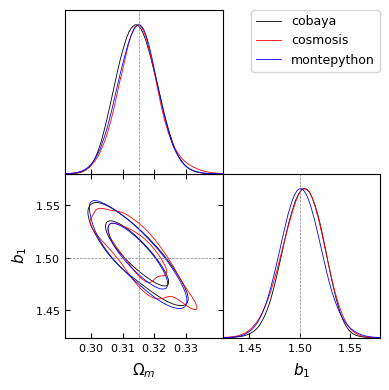

In [62]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_fs_cobaya, samples_bao_fs_cosmosis, samples_bao_fs_montepython],
                 params=['Omega_m', 'b1'], markers={'Omega_m': cosmo['Omega_m'], 'b1': 1.5})

# Wrap-up

- compressed or full-shape likelihoods are defined only once, within desilike
- bindings for Cobaya, CosmoSIS and MontePython are generated with a simple function call
- for Cobaya, the generated likelihood can be straightforwardly imported
- for CosmoSIS and MontePython, the description of nuisance parameters need be copied into the input config files